<div class='bar_title'></div>

*Smart Cities and Geospatial Data Analysis*

# Point Pattern Analysis

__Gunther Gust__ <br>
Chair for Enterprise AI <br>
Data Driven Decisions Group

Winter Semester 23/24

<img src="images/d3.png" style="width:20%; float:left;" />

<img src="images/CAIDASlogo.png" style="width:20%; float:left;" />

## Content

- Introduction & Definition
- Visualizing Point Patterns
- Random vs. Clustered Points
- Identifying Clusters

*Credits: Most of the material is taken from [Rey et al, Geographic Data Science with Python](https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html)*

# Points 


* a) Representation of __fixed objects__ in space

    * Analysis like polygons and lines (as in previous lecture)



* b) Measurements of __geographically-continuous process__ than can happen anywhere

    * = __*Point pattern*__ (focus of today) 

# Introduction

Points are spatial entities that can be understood in two fundamentally different ways: 

* On the one hand, points can be seen as __fixed objects in space__, which is to say their location is taken as given (*exogenous*). In this interpretation, the location of an observed point is considered as secondary to the value observed at the point. Think of this like measuring the number of cars traversing a given road intersection; the location is fixed, and the data of interest comes from the measurement taken at that location. The analysis of this kind of point data is very similar to that of other types of spatial data such as polygons and lines. 


* On the other hand, an observation occurring at a point can also be thought of as a site of measurement from an underlying __geographically-continuous process__. In this case, the measurement could theoretically take place anywhere, but was only carried out or conducted in certain locations. Think of this as measuring the length of birds' wings: the location at which birds are measured reflects the underlying geographical process of bird movement and foraging, and the length of the birds' wings may reflect an underlying ecological process that varies by bird. This kind of approach means that both the location and the measurement matter. __This is the perspective we will adopt in this lecture.__

When points are seen as events that could take place in several locations but only happen in a few of them, a collection of such events is called a __*point pattern*__. In this case, the __location of points__ is one of the key aspects of interest for analysis. 





Our data sample: __geo-tagged photographs.__ They could technically happen in many locations, but we usually find photos tend to concentrate only in a handful of them. 

Point patterns can be 
* __*marked*__, if more attributes are provided with the location, or 
* __*unmarked*__, if only the coordinates of where the event occurred are provided

Continuing the photo example, 
* __unmarked__ pattern: __only the location__ of photos  
* __marked__ pattern: other attributes, such as the time, camera model, or a "image quality score" available

__Point pattern analysis__ is thus concerned with the visualization, description, statistical characterization, and modeling of point patterns, trying to understand the generating process that gives rise and explains the observed data. 



Common questions in this domain include:

- *What does the pattern look like?* 
- *What is the nature of the distribution of points?* 
- *Is there any structure in the way locations are arranged over space? That is, are events clustered? or are they dispersed?*
- *Why do events occur in those places and not in others?* 

At this point, it is useful to remind ourselves of an important distinction between process and pattern. The former relates to the underlying mechanism that is at work to generate the outcome we end up observing. Because of its abstract nature, we do not get to see it. However, in many contexts, the key focus of any analysis is to learn about *what* determines a given phenomenon and *how* those factors combine to generate it. In this context, "process" is associated with the *how*. "Pattern," on the other hand, relates to the result of that process. In some cases, it is the only trace of the process we can observe and thus the only input we have to work with in order to reconstruct it. Although directly observable and, arguably, easier to tackle, pattern is only a reflection of process. The real challenge is not to characterize the former but to use it to work out the latter.

In this chapter, we provide an introduction to point patterns through geo-tagged Flickr photos from Tokyo. We will treat the phenomena represented in the data as events: photos could be taken of any place in Tokyo, but only certain locations are captured. Keep in mind this understanding of Tokyo photos is not immutable: one could conceive cases where it makes sense to take those locations as given and look at the properties of each of them ignoring their "event" aspect. However, in this context, we will focus on those questions that relate to location and the collective shape of locations. The use of these tools will allow us to transform a long list of unintelligible XY coordinates into tangible phenomena with a characteristic spatial structure, and to answer questions about the center, dispersion, and clustering of attractions in Tokyo for Flickr users.

## Patterns in Tokyo photographs

In this chapter we will explore metadata from a sample of geo-referenced images uploaded to [Flickr](https://www.flickr.com/) and extracted thanks to the [100m Flickr dataset](https://webscope.sandbox.yahoo.com/catalog.php?datatype=i&did=67). In doing so, we will introduce a few approaches that help us better understand the distribution and characteristics of a point pattern. 


* Where do people take pictures? 
* Why do certain places attract many more photographers than others? 



The rise of new forms of data such as geo-tagged photos uploaded to online services is creating __new ways for researchers to study and understand cities.__ 

In [1]:
import numpy
import pandas
import geopandas
import pysal
import libpysal
import seaborn
import contextily
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

Then, let us load some data about picture locations from Flickr:


In [2]:
db = pandas.read_csv("https://raw.githubusercontent.com/GuntherGust/sc_gdsa_data/main//tokyo_clean.csv")

In [3]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               10000 non-null  object 
 1   longitude             10000 non-null  float64
 2   latitude              10000 non-null  float64
 3   date_taken            10000 non-null  object 
 4   photo/video_page_url  10000 non-null  object 
 5   x                     10000 non-null  float64
 6   y                     10000 non-null  float64
dtypes: float64(4), object(3)
memory usage: 547.0+ KB


The table contains the following information about the sample of 10,000 photographs: the __ID__ of the user who took the photo, the __location__ expressed as latitude and longitude columns, a transformed version of those coordinates expressed in Pseudo Mercator, the __timestamp__ when the photo was taken, and the __URL__ where the picture they refer to is stored online.

Note that the data is provided as a `.csv` file, so the spatial information is encoded as separate columns, one for each coordinate. This is in contrast to how we have consumed spatial data in previous chapters, where spatial information was stored in a single column and encoded in geometry objects.

## Visualizing point patterns

There are many ways to visualize geographic point patterns, and the choice of method depends on the intended message. 

### Showing patterns as dots on a map

The first step to get a sense of what the spatial dimension of this dataset looks like is to plot it. At its most basic level, we can generate a scatterplot with `seaborn` in Figure 1: 


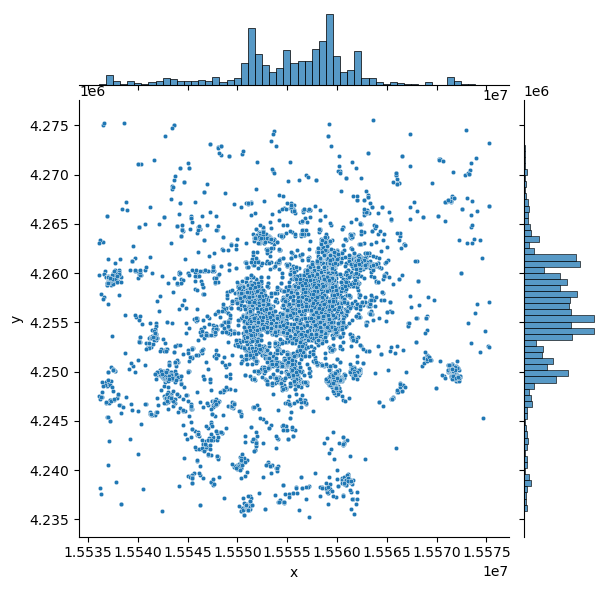

In [4]:
# Generate scatter plot
seaborn.jointplot(x="x", y="y", data=db, s=10);

This is a good start: we can see dots tend to be concentrated in the center of the covered area in a non-random pattern. Furthermore, within the broad pattern, we can also see there seems to be more localized clusters. However, the plot above has two key drawbacks: one, it lacks geographical context; and two, there are areas where the density of points is so large that it is hard to tell anything beyond a blue blurb. 



### Addition of a Basemap



Start with the context. The easiest way to provide additional context is by overlaying a tile map from the internet. Let us quickly call `contextily` for that, and integrate it with `jointplot` to create the following figure. 

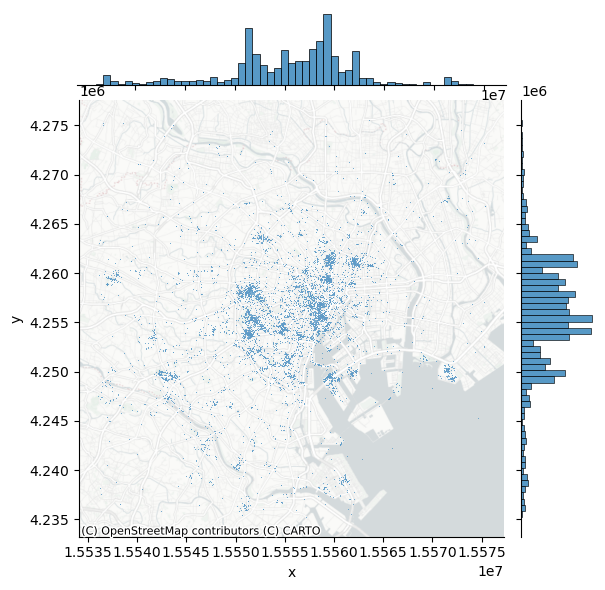

In [5]:
# Generate scatter plot
joint_axes = seaborn.jointplot(
    x="x", y="y", data=db, s=0.5
)
contextily.add_basemap(
    ax = joint_axes.ax_joint,
    source=contextily.providers.CartoDB.PositronNoLabels,
);

Note how we can pull out the axis where the points are plotted and add the basemap there, specifying the CRS as WGS84, since we are plotting longitude and latitude. Compared to the previous plot, adding a basemap to our initial plot makes the pattern of Flickr data clearer.

### Showing density with hexbinning


__Problem:__ Too many photos are concentrated in some areas, hard to discern any pattern

__Solution:__ ???

#### Solution: Aggregation!

* Administrative districts
* Squared-binning
* Hex-binning
* Kernel-density estimation (KDE)

For example, in the middle of the map in Figure 3, toward the right, there appears to be the highest concentration of pictures taken; the sheer amount of dots on the maps in some parts obscures whether all of that area receives as many pics or whether, within there, some places receive a particularly high degree of attention.

One solution to get around cluttering is to generatig a regular grid (either squared or hexagonal), count how many dots fall within each grid cell, and present it as we would any other choropleth. This is attractive because it is simple, intuitive and, if fine enough, the regular grid removes some of the area distortions choropleth maps may induce. For this illustration, let us use use hexagonal binning (sometimes called hexbin) because it has slightly nicer properties than squared grids, such as less shape distortion and more regular connectivity between cells. Creating a hexbin two-dimensional histogram is straightforward in Python using the `hexbin` function to create the following plot:

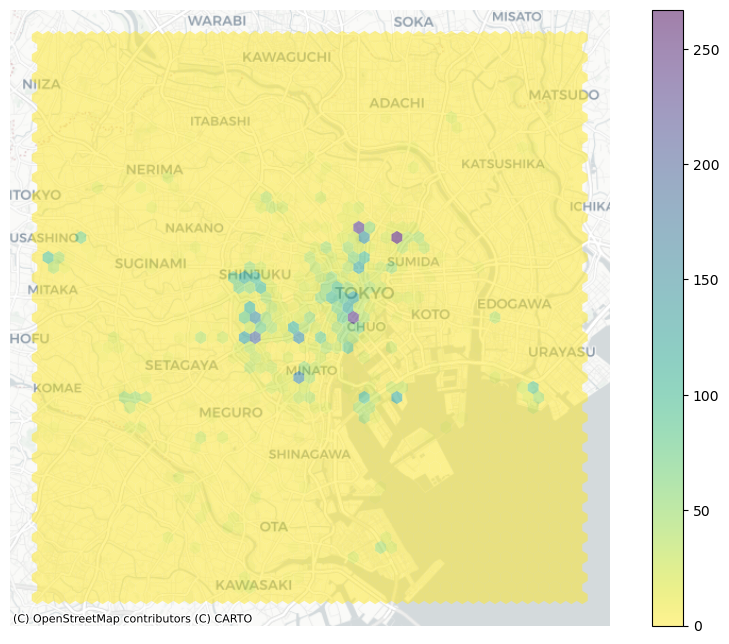

In [6]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(11, 8))

# Creates a hexagonal binning plot on the axes 'ax'.
hb = ax.hexbin(
    db["x"],       # Uses 'x' column from 'db' for the x-coordinates.
    db["y"],       # Uses 'y' column from 'db' for the y-coordinates.
    gridsize=50,   # Sets the number of hexagons in the x-direction (grid size).
    linewidths=0,  # Sets the width of the lines that will make up each hexagon (0 for no lines).
    alpha=0.5,     # Sets the transparency of the hexagons (0.5 for 50% transparency).
    cmap="viridis_r", # Applies the 'viridis' colormap in reverse for coloring the hexagons.
)

# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Add legend
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

Voila, this allows a lot more detail! It is now clear that the majority of photographs relate to much more localized areas, and that the previous map was obscuring this.

Grids represent a __discretization__ of an essentially __continuous phenomenon.__  

* Distortions, most notable the __modifiable areal unit problem__: 

<img src="images/MAUP.png" style="width:40%; float:left;" />



The __Kernel density estimation (KDE)__ --- an empirical approximation of the probability density function --- overcomes this problem. 

### Kernel density estimation (KDE)






A very intuitive explanation of KDE is given [here](https://www.spatialanalysisonline.com/HTML/?density__kernels_and_occupancy.htm). The principle can be explained well based on the following figure.



<img src="images/kde.png" style="width:70%; float:left;" />

Instead of overlaying a grid of squares of hexagons and count how many points fall within each, a KDE lays a grid of points over the space of interest on which it places kernel functions that count points around them with a different weight based on the distance. These counts are then aggregated to generate a global surface with probability. The most common kernel function is the Gaussian one (as in the previous plot), which applies a normal distribution to weight points. The result is a continuous surface with a probability function that may be evaluated at every point. 

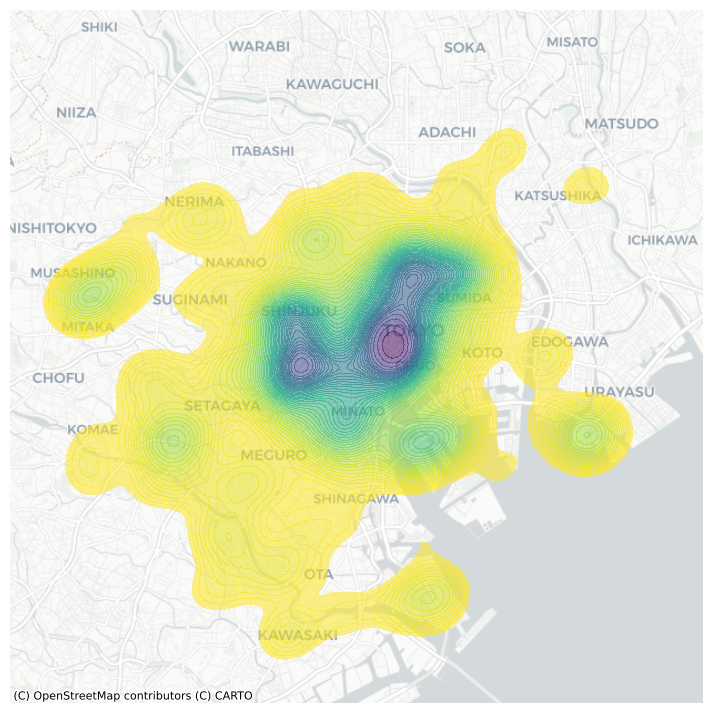

In [7]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Creates a Kernel Density Estimate (KDE) plot using Seaborn.
seaborn.kdeplot(
    x="x",           # Specifies the 'x' column from 'db' for the x-axis values.
    y="y",           # Specifies the 'y' column from 'db' for the y-axis values.
    data=db,         # Sets 'db' as the data source for the plot.
    n_levels=50,     # Sets the number of contour levels (50 levels for the density plot).
    fill=True,       # Fills the contours for a more visual density representation.
    alpha=0.55,      # Sets the transparency of the fill (55% transparency).
    cmap="viridis_r", # Uses the reversed 'viridis' colormap for coloring the plot.
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()

The result is a smoother output that captures the same structure of the hexbin but "eases" the transitions between different areas. This provides a better generalization of the theoretical probability distribution over space.  Technically, the continuous nature of the KDE function implies that for any given point the probability of an event is 0. However, as the area around a point increases, the probability of an event within that area can be obtained.  This is useful in some cases, but it is mainly of use to escape the restrictions imposed by a regular grid of hexagons or squares. 

The visualization highlights clusters (e.g. in the city center). 

* Is this visual impression __accurate__ (are the clusters significant or just random)?
* Where are the areas of significant __clustering or dispersion?__



The following methods help us address these questions.

## Clustering (and Randomness)






__Motivation:__ How __even__ (or uneven) is a point pattern? 

(Recall __global spatial autocorrelation:__ What is the overall degree of spatial association between feature values?) 


Spatial statistics on point patterns are often concerned with how *even* a distribution of points is. By this, we mean whether points tend to ball cluster near one another or disperse evenly throughout the problem area. Questions like this refer to the *intensity* or *dispersion* of the point pattern overall. In the jargon of the last two chapters, this focus resembles the goals we examined when we introduced [global spatial autocorrelation](06_spatial_autocorrelation): what is the overall degree of *clustering* we observe in the pattern? Spatial statistics has devoted plenty of effort to understand this kind of clustering. This section will cover methods useful for identifying clustering in point patterns.

### Measures:

* Quadrat statistics
* Ripley's G
* Ripley's F

The first set of techniques, **quadrat** statistics, receive their name after their approach to split the data up into small areas (quadrants). Once created, these "buckets" are used to examine the uniformity of counts across them. The second set of techniques all derive from Ripley (1988) and involve measurements of the distance between points in a point pattern. 

### Quadrat statistics

__Intuition:__

* Split data up into small areas (quadrants)
* Asses the uniformity of counts in these quadrants ("buckets")

In [8]:
from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern,
)

# Sample some photos from an arbitrary user
user = db.query('user_id == "95795770@N00"')
coordinates = user[["x", "y"]].values

For illustration, we compare the __user photos__ against a __*completely spatially random* process__ (so-called *Poisson point process*).

In [9]:
# Generates a random pattern based on the Poisson distribution.
random_pattern = random.poisson(hull= coordinates, # bounding box to use (computed from observations) 
                                size=len(coordinates)) #number of points to generate

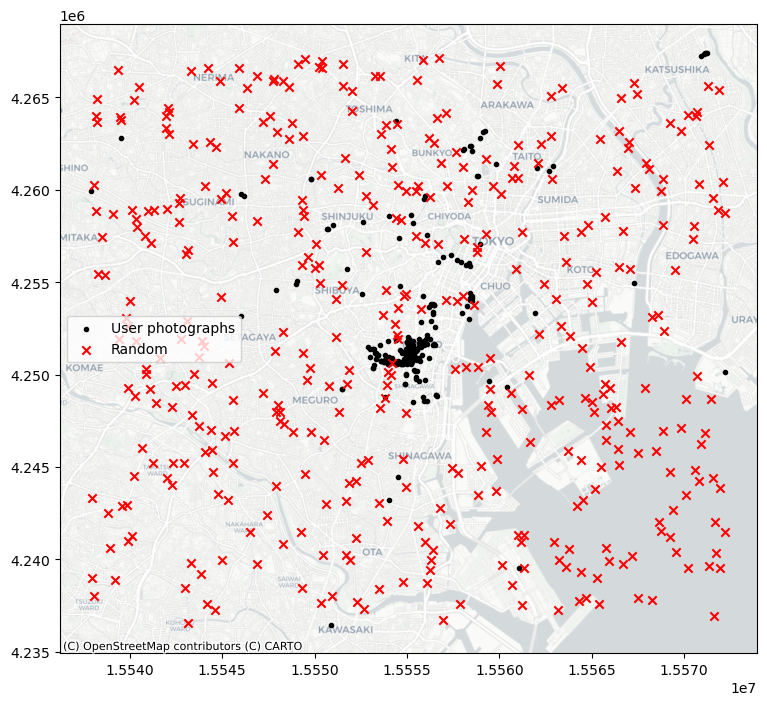

In [10]:
f, ax = plt.subplots(1, figsize=(9, 9))
plt.scatter(
    *coordinates.T, #transposes and unpacks the coordinate tuples (see e.g. https://geekflare.com/python-unpacking-operators/)
    color="k",
    marker=".",
    label="User photographs"
)
plt.scatter(*random_pattern.T, color="r", marker="x", label="Random")
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
ax.legend(ncol=1, loc="center left");

#### Compute Quadrat statistics


Quadrat statistics examine the spatial distribution of points in an area in terms of the count of observations that fall within a given cell. By examining whether observations are spread *evenly* over cells, the quadrat approach aims to estimate whether points are spread out, or if they are clustered into a few cells. Strictly speaking, quadrat statistics examine the *evenness* of the distribution over cells using a $\chi^2$ statistical test common in the analysis of contingency tables. 

In the `pointpats` package, you can visualize the results using the following `QStatistic.plot()` method. This shows the grid used to count the events, as well as the underlying pattern, shown in the figure:

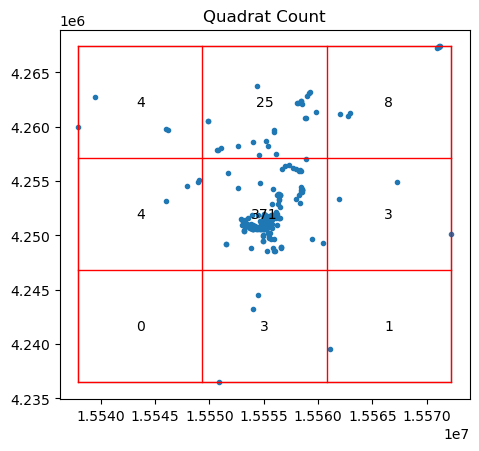

In [11]:
qstat = QStatistic(coordinates)
qstat.plot();

In this case, for the default of a three-by-three grid spanning the point pattern, we see that the central square has over 350 observations, but the surrounding cells have many fewer Flickr photographs. This means that the chi-squared test (which compares how likely this distribution is if the cell counts are uniform) will be statistically significant, with a very small $p$-value:


Compute __statistical significance__ using chi-squared test (which compares how likely this distribution is if the cell counts follow a uniform distribution):

In [12]:
qstat.chi2_pvalue

0.0

In contrast, our totally __random point process__ will have nearly the same points in every cell:

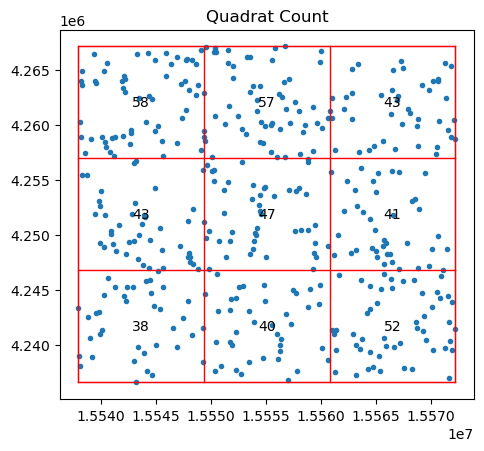

In [13]:
qstat_null = QStatistic(random_pattern)
qstat_null.plot();

This means its p-value will be large and likely not significant:


In [14]:
qstat_null.chi2_pvalue

0.30197779902598104

#### Caution: 

__Irregular extent__ of pattern can lead to wrong conclusions!


Be careful, however; the fact that quadrat counts are measured in a __*regular tiling*__ that is overlaid on top of the potentially __irregular extent__ of our pattern can mislead us. In particular, irregular *but random* patterns can be mistakenly found "significant" by this approach. Consider our random set generated within the alpha shape polygon, with the quadrat grid overlaid:

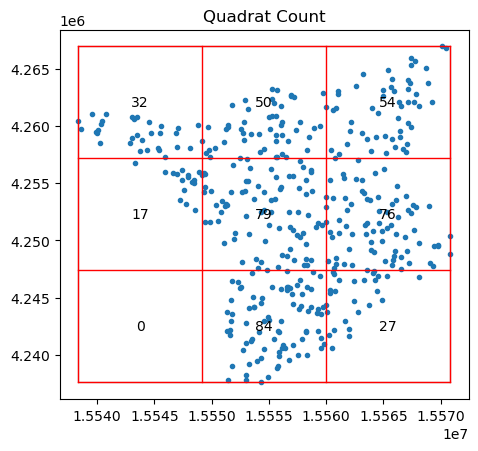

In [15]:
alpha_shape = libpysal.cg.alpha_shape_auto( #compute alpha shape (= convex hull) of photo locations
    coordinates)

random_pattern_ashape = random.poisson( #generate random pattern
    alpha_shape, size=len(coordinates)
)

qstat_null_ashape = QStatistic(random_pattern_ashape) #compute quadrat statistics
qstat_null_ashape.plot();

In [16]:
qstat_null_ashape.chi2_pvalue

1.285933282778539e-28

The quadrat test finds this to be __*statistically non-random*,__ while our simulating process ensured that *within the given study area*, the pattern is a complete spatially-random process! 

##### Summary: Quadrat statistic 

* Suffers from irregular study areas
* Basically tests __uniformity of points *and* the shape of their extent__

The following methods,__Ripley's functions__, mitigate this problem.

Thus, quadrat counts can have issues with irregular study areas, and care should be taken to ensure that clustering is not mistakenly identified. One way to interpret the quadrat statistic that reconciles cases like the one above is to think of it as a test that considers both the __uniformity of points *and* the shape of their extent__ to examine whether the resulting pattern is uniform across a regular grid. In some cases, this is a useful tool; in others, this needs to be used with caution.

### Ripley's alphabet of functions


The second group of spatial statistics we consider focuses on the distributions of two quantities in a point pattern: nearest neighbor distances and what we will term "gaps" in the pattern. They derive from seminal work by Ripley (1991) on how to characterize clustering or co-location in point patterns. Each of these characterizes an aspect of the point pattern as we increase the distance range from each point to calculate them. 


#### Ripley's G

Ripley's $G$ 

* summarizes the distances between __each point__ in the pattern and its __nearest neighbor__ and
* __compares__ it to a spatially random process

Idea: A __"clustered" pattern__ must have more points near one another than a pattern that is "dispersed"

Ripley's $G$ keeps track of the proportion of points for which the nearest neighbor is within a given distance threshold, and plots that cumulative percentage against the increasing distance radii. The distribution of these cumulative percentages has a distinctive shape under completely spatially random processes. The intuition behind Ripley's G goes as follows: we can learn about how similar our pattern is to a spatially random one by computing the cumulative distribution of nearest neighbor distances over increasing distance thresholds, and comparing it to that of a set of simulated patterns that follow a known spatially random process. Usually, a spatial Poisson point process is used as such reference distribution. 




If $G$ function 
* increases __*rapidly*__ with distance, we probably have a __clustered__ pattern. 
* increases __*slowly*__ with distance, we have a __dispersed__ pattern. 
* Something in the middle will be difficult to distinguish from pure chance.


In the figure this nearest neighbor logic is visualized with the red dots being a detailed view of the point pattern and the black arrows indicating the nearest neighbor to each point. Note that sometimes two points are *mutual* nearest neighbors (and so have arrows going in both directions), but some are not. 

In [17]:
%%capture captured_plot
#Cell magic command captures the plot created in this cell

# Code generated for this figure is available on the web version of the book.
f, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].scatter(*random_pattern.T, color="red")
ax[1].scatter(
    *random_pattern.T,
    color="red",
    zorder=100,
    marker=".",
    label="Points"
)
nn_ixs, nn_ds = PointPattern(random_pattern).knn(1)
first = True
for coord, nn_ix, nn_d in zip(random_pattern, nn_ixs, nn_ds):
    dx, dy = random_pattern[nn_ix].squeeze() - coord
    arrow = ax[1].arrow(
        *coord,
        dx,
        dy,
        length_includes_head=True,
        overhang=0,
        head_length=300 * 3,
        head_width=300 * 3,
        width=50 * 3,
        linewidth=0,
        facecolor="k",
        head_starts_at_zero=False
    )
    if first:
        plt.plot(
            (1e100, 1e101),
            (0, 1),
            color="k",
            marker="<",
            markersize=10,
            label="Nearest Neighbor to Point",
        )
    first = False

ax[0].axis([1.554e7, 1.556e7, 4240000, 4260000])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xticks([])
ax[0].set_yticks([])
f.tight_layout()
ax[1].legend(bbox_to_anchor=(0.5, -0.06), fontsize=16)
plt.show()

#### Nearest-neighbor distance

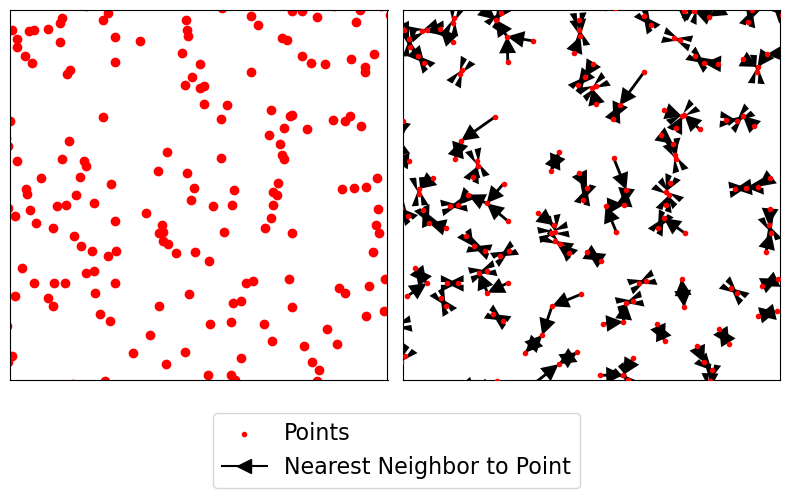

None

In [18]:
display(captured_plot()) #the captured plot is displayed here

#### Calculation of Ripley's G


To caluclate Ripley's $G$,  in the `pointpats` package, we can use the `g_test` function, which computes both the `G` function for the empirical data *and* these hypothetical replications under a completely spatially random process.

In [19]:
g_test = distance_statistics.g_test(
    coordinates, support=40, keep_simulations=True
)

#### Visualization

In [20]:
%%capture captured_plot 
# Cell magic command captures the plot created in this cell

f, ax = plt.subplots(
    1, 2, figsize=(9, 3), gridspec_kw=dict(width_ratios=(6, 3))
)
# plot all the simulations with very fine lines
ax[0].plot(
    g_test.support, g_test.simulations.T, color="k", alpha=0.01
)
# and show the average of simulations
ax[0].plot(
    g_test.support,
    numpy.median(g_test.simulations, axis=0),
    color="cyan",
    label="median simulation",
)


# and the observed pattern's G function
ax[0].plot(
    g_test.support, g_test.statistic, label="observed", color="red"
)

# clean up labels and axes
ax[0].set_xlabel("distance")
ax[0].set_ylabel("% of nearest neighbor\ndistances shorter")
ax[0].legend()
ax[0].set_xlim(0, 2000)
ax[0].set_title(r"Ripley's $G(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates.T)

# and clean up labels and axes there, too
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title("Pattern")
f.tight_layout()


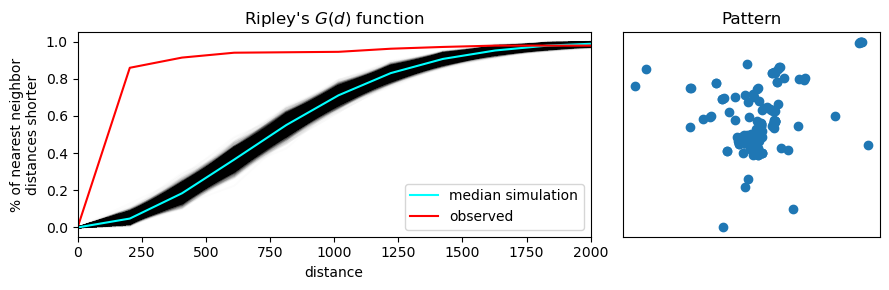

None

In [21]:
display(captured_plot()) #the captured plot is displayed here

On the left, we plot the $G(d)$ function, with distance-to-point ($d$) on the horizontal axis and the fraction of nearest neighbor distances smaller than $d$ on the right axis. The empirical cumulative distribution of nearest neighbor distances is shown in red. In blue, simulations (like the `random` pattern shown in the previous section) are shown. The bright blue line represents the average of all simulations, and the darker blue/black band around it represents the middle 95% of simulations. 

We see that the red empirical function rises much faster than simulated completely spatially random patterns. This means that the observed pattern of this user's Flickr photographs are *closer* to their nearest neighbors than would be expected from a completely spatially random pattern. The pattern is *clustered.*

#### Ripley's F

The second function we introduce is Ripley's $F$. Where the $G$ function works by analyzing the distance *between* points in the pattern, the *F* function works by analyzing the __distance *to* points__ in the pattern __from locations in empty space__. 


* If the pattern has __large gaps or empty areas,__ the $F$ function will increase __slowly.__ 
* If the pattern is highly __dispersed__, then the $F$ function will increase __rapidly.__ 

That is why the $F$ function is called the "the empty space function", since it characterizes the typical distance from arbitrary points in empty space to the point pattern. More explicitly, the $F$ accumulates, for a growing distance range, the percentage of points that can be found within that range from a random point pattern generated within the extent of the observed pattern. If the pattern has large gaps or empty areas, the $F$ function will increase slowly. But, if the pattern is highly dispersed, then the $F$ function will increase rapidly. The shape of this cumulative distribution is then compared to those constructed by calculating the same cumulative distribution between the random pattern and an additional, random one generated in each simulation step.

We can use similar tooling to investigate the $F$ function, since it is so mathematically similar to the $G$ function. This is implemented identically using the `f_test` function in `pointpats`. Since the $F$ function estimated for the observed pattern increases *much* more slowly than the $F$ functions for the simulated patterns, we can be confident that there are many gaps in our pattern; i.e., the pattern is *clustered*. 

In [22]:
f_test = distance_statistics.f_test(
    coordinates, support=40, keep_simulations=True
)

We can visualize this as before: 

In [23]:
%%capture captured_plot 
# Cell magic command captures the plot created in this cell

f, ax = plt.subplots(
    1, 2, figsize=(9, 3), gridspec_kw=dict(width_ratios=(6, 3))
)

# plot all the simulations with very fine lines
ax[0].plot(
    f_test.support, f_test.simulations.T, color="k", alpha=0.01
)
# and show the average of simulations
ax[0].plot(
    f_test.support,
    numpy.median(f_test.simulations, axis=0),
    color="cyan",
    label="median simulation",
)

# and the observed pattern's F function
ax[0].plot(
    f_test.support, f_test.statistic, label="observed", color="red"
)

# clean up labels and axes
ax[0].set_xlabel("distance")
ax[0].set_ylabel("% of nearest point in pattern\ndistances shorter")
ax[0].legend()
ax[0].set_xlim(0, 2000)
ax[0].set_title(r"Ripley's $F(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates.T)

# and clean up labels and axes there, too
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title("Pattern")
f.tight_layout()
plt.show()

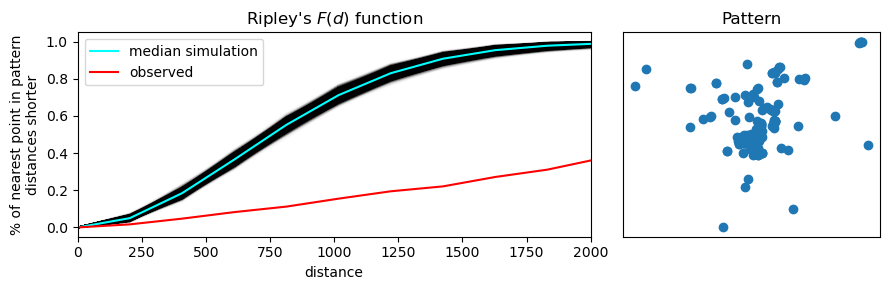

None

In [24]:
display(captured_plot()) #the captured plot is displayed here

__Ripley's "alphabet"__ extends to several other letter-named functions that can be used for conducting point pattern analysis in this vein. Good "next steps" in your point pattern analysis journey include the [book](https://doi.org/10.1201/b19708) by Baddeley (2015), and the `pointpats` [documentation](https://github.com/pysal/pointpats/blob/main/notebooks/distance_statistics-numpy-oriented.ipynb)  for guidance on how to run these in Python.

## Identifying clusters

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)


<video width=500 height=300 
       src="https://raw.githubusercontent.com/GuntherGust/sc_gdsa_data/main/DBSCAN.mp4"  
       controls>
</video>

Credits to [statquest](https://statquest.org/) for the video.


In this final section, we will learn a method to identify clusters of points, based on their density across space. To do this, we will use the widely used `DBSCAN` algorithm. For this method, a cluster is a concentration of at least `m` points, each of them within a distance of `r` of at least another point in the cluster. Points in the dataset are then divided into three categories:

* *Noise*, for those points outside a cluster.
* *Cores*, for those points inside a cluster whith at least `m` points in the cluster within distance `r`.
* *Borders* for points inside a cluster with less than `m` other points in the cluster within distance `r`.

Both `m` and `r` need to be __prespecified by the user__ before running `DBSCAN`. This is a critical point, as their value can influence significantly the final result. 


### DBSCAN in python
The heavy lifting is done by the method `DBSCAN`, part of the excellent machine learning library `scikit-learn`. Running the algorithm is similar to how we ran K-Means in the previous lectures. We first set up the details:

In [25]:
# Initialize DBSCAN clustering.
algo = DBSCAN(
    eps=100,        # Maximum distance for neighborhood points.
    min_samples=50  # Minimum number of samples for a core point.
)


#### Data: convert to metric CRS

In [26]:
## Express points in metres
# Convert lon/lat into Point objects + set CRS
pts = geopandas.points_from_xy(
    db["longitude"],
    db["latitude"],
    crs="EPSG:4326"
)
# Convert lon/lat points to Japanese CRS in metres
pts = geopandas.GeoDataFrame({"geometry": pts}).to_crs(epsg=2459)
# Extract coordinates from point objects into columns
db["X_metres"] = pts.geometry.x
db["Y_metres"] = pts.geometry.y

Once ready, we _"fit"_ it to our data, but note that we first need to express the longitude and latitude of our points in metres (see code for that on the side cell).

In [27]:
algo.fit(db[["X_metres", "Y_metres"]])

DBSCAN(eps=100, min_samples=50)

Once fit, `algo` contains the required information to access all the results of the algorithm. The `core_sample_indices_` attribute contains the indices (order, starting from zero) of each point that is classified as a *core*. We can have a peek into it to see what it looks like:


In [28]:
# Print the first 5 elements of `cs`
algo.core_sample_indices_[:5]

array([12, 25, 28, 46, 63], dtype=int64)

The printout above has a variable length, depending on how many cores the algorithm finds.



The second attribute of interest is `labels_`:

In [29]:
algo.labels_[:100]

array([-1, -1, -1, -1,  8, -1,  7, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,
       -1, -1, 12, -1, -1, -1, -1, -1,  1, -1, -1,  2, -1, -1, -1, -1, -1,
       -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  3, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  8, -1,  4,  4, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1,
       -1, -1, 10, -1, -1,  1, -1,  3, -1, -1, -1,  2, -1, -1, -1],
      dtype=int64)

The `labels_` attribute always has the same length as the number of points used to run DBSCAN. 
* Each __value__ represents the __index of the cluster__ a point belongs to. 
* If the point is classified as __noise__, it receives a __−1.__ 

Above, we can see that the fifth point belongs to cluster 8, while many others in the list are effectively not part of any cluster. 


### Visualization of Clusters


To make things easier later on, let us turn the labels into a `Series` object that we can index in the same way as our collection of points:

In [30]:
lbls = pandas.Series(algo.labels_, index=db.index)

We will start just by coloring points in a cluster in red and noise in grey.


In [31]:
%%capture captured_plot 
# Cell magic command captures the plot created in this cell

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Subset points that are not part of any cluster (noise)
noise = db.loc[lbls == -1, ["x", "y"]]
# Plot noise in grey
ax.scatter(noise["x"], noise["y"], c="grey", s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(
    db.loc[db.index.difference(noise.index), "x"],
    db.loc[db.index.difference(noise.index), "y"],
    c="red",
    linewidth=0,
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

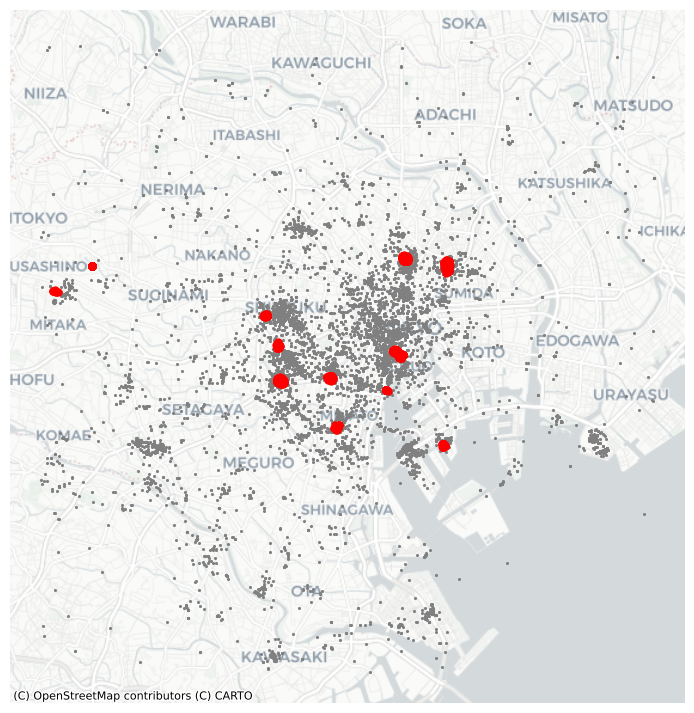

None

In [32]:
display(captured_plot()) #the captured plot is displayed here

This is a first good pass. The algorithm is able to identify a few clusters with high density of photos. However, as we mentioned {ref}`when discussing DBSCAN <concepts_H:dbscan>`, this is all contingent on the parameters we arbitrarily set. Depending on the maximum radious (`eps`) we set, we will pick one type of cluster or another: a higher (lower) radious will translate in less (more) local clusters. Equally, the minimum number of points required for a cluster (`min_samples`) will affect the implicit size of the cluster. Both parameters need to be set before running the algorithm, so our decision will affect the final outcome quite significantly.


Let's run through a case with very different parameter values. For example, let's pick a larger radious (e.g. 500m) and a smaller number of points (e.g. 10):

In [33]:
# Set up algorithm
algo = DBSCAN(eps=500, min_samples=10)
# Fit to Tokyo projected points
algo.fit(db[["X_metres", "Y_metres"]])
# Store labels
lbls = pandas.Series(algo.labels_, index=db.index)

In [42]:
%%capture captured_plot 
# Cell magic command captures the plot created in this cell

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Assign labels to tokyo table dynamically and
# subset points that are not part of any cluster (noise)
noise = db.assign(
    lbls=lbls
).query("lbls == -1")
# Plot noise in grey
ax.scatter(
    noise["X_metres"], 
    noise["Y_metres"], 
    c='grey', 
    s=5, 
    linewidth=0
)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(
    db.loc[db.index.difference(noise.index), "X_metres"], 
    db.loc[db.index.difference(noise.index), "Y_metres"],
    c="red", 
    linewidth=0
)

# Display the figure
plt.show()

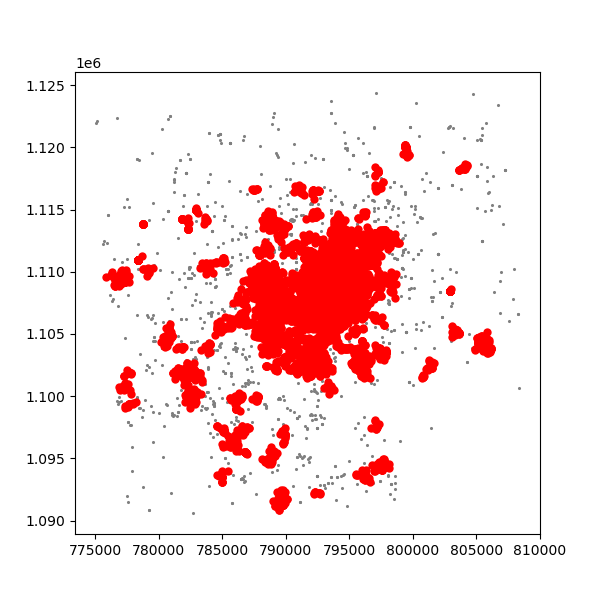

None

In [43]:
display(captured_plot()) #the captured plot is displayed here

The output is now very different, isn't it? This exemplifies how different parameters can give rise to substantially different outcomes, even if the same data and algorithm are applied.


### Excursus: Advanced plotting

As we have seen, the choice of parameters plays a crucial role in the number, shape and type of clusters founds in a dataset. To allow an easier exploration of these effects, in this section we will turn the computation and visualization of `DBSCAN` outputs into a __single function.__ This in turn will allow us to build an __interactive tool__ later on.



In [36]:
%matplotlib widget

import ipympl

from ipywidgets import interact, fixed, Output

output = Output()

def clusters(db, eps, min_samples):
    '''
    Compute and visualize DBSCAN clusters    
    ...
    
    Arguments
    ---------
    db          : (Geo)DataFrame
                  Table with at least columns `X` and `Y` for point coordinates
    eps         : float
                  Maximum radious to search for points within a cluster
    min_samples : int
                  Minimum number of points in a cluster
    '''
    with output:
        output.clear_output(wait=True) 
    
    algo = DBSCAN(eps=eps, min_samples=min_samples)
    algo.fit(db[['X_metres', 'Y_metres']])
    lbls = pandas.Series(algo.labels_, index=db.index)

    f, ax = plt.subplots(1, figsize=(6, 6))
    noise = db.loc[lbls==-1, ['X_metres', 'Y_metres']]
    ax.scatter(noise['X_metres'], noise['Y_metres'], c='grey', s=5, linewidth=0)
    ax.scatter(
        db.loc[db.index.difference(noise.index), 'X_metres'],
        db.loc[db.index.difference(noise.index), 'Y_metres'],
        c='red', 
        linewidth=0
    )
    return plt.show()

The function takes the following three arguments:

1. `db`: a `(Geo)DataFrame` containing the points on which we will try to find the clusters.
1. `eps`: a number (maybe with decimals, hence the `float` label in the documentation of the function) specifying the maximum distance to look for neighbors that will be part of a cluster.
1. `min_samples`: a count of the minimum number of points required to form a cluster.



Let us see how the function can be used. For example, let us replicate the plot above, with a minimum of 10 points and a maximum radious of 500 metres:

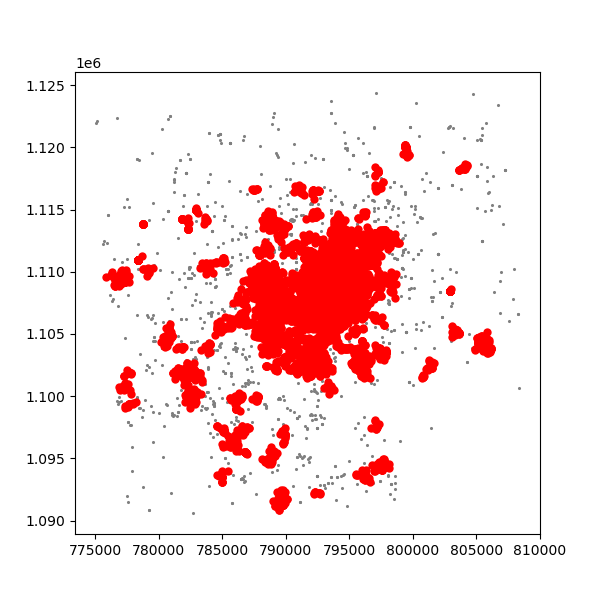

In [37]:
clusters(db, 500, 10)

### Excursus: Interactive Cluster Plots

However, this could be even more interesting if we didn't have to write each time the parameters we want to explore. To change that, we can create a quick interactive tool that will allow us to modify both parameters with sliders. To do this, we will use the library [`ipywidgets`](https://ipywidgets.readthedocs.io). Let us first do it and then we will analyse it bit by bit:

In [44]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [45]:
interact(
    clusters,                 # Method to make interactive
    db=fixed(db),          # Data to pass on db (does not change)
    eps=(50, 500, 50),        # Range start/end/step of eps
    min_samples=(50, 300, 50) # Range start/end/step of min_samples
)


interactive(children=(IntSlider(value=250, description='eps', max=500, min=50, step=50), IntSlider(value=150, …

<function __main__.clusters(db, eps, min_samples)>

Phew! That is cool, isn't it? Once passed the first excitement, let us have a look at how we built it, and how you can modify it further on. A few points on this:

* First, `interact` is a method that allows us to pass an arbitrary function (like `clusters`) and turn it into an interactive widget where we modify the values of its parameters through sliders, drop-down menus, etc.
* What we need to pass to `interact` is the name of the function we would like to make interactive (`clusters` in this case), and all the parameters it will take.
* Since in this case we do not wish to modify the dataset that is used, we pass `tokyo` as the `db` argument in `clusters` and fixate it by passing it first to the `fixed` method.
* Then both the radious `eps` and the minimum cluster size `min_samples` are passed. In this case, we do want to allow interactivity, so we do not use `fixed`. Instead, we pass a tuple that specifies the range and the step of the values we will allow to be used. 
* In the case of `eps`, we use `(50, 500, 50)`, which means we want `r` to go from 50 to 500, in jumps of 50 units at a time. Since these are specified in metres, we are saying we want the range to go from 50 to 500 metres in increments of 50 metres.
* In the case of `min_samples`, we take a similar approach and say we want the minimum number of points to go from 50 to 300, in steps of 50 points at a time.

The above results in a little interactive tool that allows us to play easily and quickly with different values for the parameters and to explore how they affect the final outcome.

### Why did we use DBSCAN (and not k-Means)?


* Ability to identify __arbitrary cluster shapes:__ DBSCAN excels at discovering clusters of arbitrary shapes, which is often the case in spatial data. Unlike algorithms like K-means, which assume spherical cluster shapes, DBSCAN can handle more complex spatial patterns.

* Noise and __Outlier Detection:__ Spatial data often contains noise and outliers. DBSCAN is designed to identify and exclude noise and outliers, treating them as separate from actual clusters. This feature is especially useful in spatial datasets where such anomalies are common.

* No Need to Specify __Cluster Count:__ In spatial analysis, the number of clusters may not be known a priori. DBSCAN does not require pre-specifying the number of clusters; it determines the clusters based on the data's density.

* __Density-based Clustering:__ DBSCAN groups points that are densely packed together, separating regions of high density from those of low density. This approach is naturally aligned with many spatial datasets where clusters are formed based on density.

## Summary

- __Visualizing Point Patterns__
    * Aggretation via Hexbins and Kernel Density Estimation

    
- __Evaluating clustering and disperion in point patterns__
    * Quadrat Statistic
    * Ripley's G
    * Ripley's F
    
- __Identifying Clusters__
    * DBSCAN


## Further Ressources

For a much deeper and conceptual discussion of the analysis of spatial point patterns, consult Baddeley, Rubak and Turner. Their coverage is often the canonical resource for people interested in this topic: 

Baddeley, Adrian, Ege Rubak, and Rolf Turner. 2015. [*Spatial Point Patterns: Methodology and Applications with R*. Boca Raton, FL: CRC Press.](https://doi.org/10.1201/b19708)


<img src="images/d3.png" style="width:50%; float:center;" />
